In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import EstimatorV2 as AerEstimator

from scipy.optimize import minimize

In [3]:
num_qubits = 4
initial_states = []

for k in range(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.x(num_qubits - 1 - k)  # Flip one qubit to prepare |φ_k⟩
    initial_states.append(qc)

## Hamiltonian for transverse ising model

Hamiltonian is given by $H = a \sum_{i=1}^{N}X_i + J \sum_{\langle i,j \rangle}^{N} Z_i Z_j$

In [4]:
def transverse_field_ising_hamiltonian(N, a=1.0, J=1.0):
    x_terms = [("X", [i], a) for i in range(N)]
    z_terms = [("ZZ", [i, i + 1], J) for i in range(N - 1)]

    return SparsePauliOp.from_sparse_list(x_terms + z_terms, num_qubits=N)


hamiltonian = transverse_field_ising_hamiltonian(num_qubits)

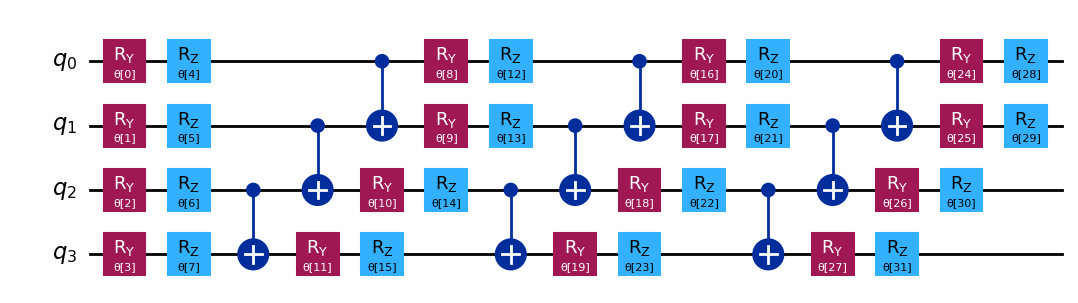

In [5]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(hamiltonian.num_qubits).decompose()

ansatz.draw("mpl")

In [6]:
weights = np.arange(num_qubits, 0, -1)

print(weights)

[4 3 2 1]


In [7]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "total_energy": [],
    "eigenstates_energies": [[] for _ in range(num_qubits)],
}


def initialize_cost_history_dict():
    cost_history_dict["prev_vector"] = None
    cost_history_dict["iters"] = 0
    cost_history_dict["total_energy"] = []
    cost_history_dict["eigenstates_energies"] = [[] for _ in range(num_qubits)]

## Weighted sum of expectation values
$\text{SSVQE\_Cost}(\theta) = \sum_k w_k \langle \psi_k(\theta) | H | \psi_k(\theta) \rangle$

In [8]:
def ssvqe_cost_func(params, ansatz, hamiltonian, estimator, initial_states, weights):
    pubs = []

    for init_state in initial_states:
        full_circuit = init_state.compose(ansatz)
        pubs.append((full_circuit, [hamiltonian], [params]))

    result = estimator.run(pubs=pubs).result()
    energies = [r.data.evs[0] for r in result]

    weighted_energy = sum(w * e for w, e in zip(weights, energies))

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["total_energy"].append(weighted_energy)

    for i in range(num_qubits):
        cost_history_dict["eigenstates_energies"][i].append(energies[i])

    print(f"[Iter {cost_history_dict['iters']}] Cost: {weighted_energy:.6f}")

    return weighted_energy

In [15]:
estimator = AerEstimator()
estimator.options.shots = 10000

In [17]:
params_init = np.random.rand(ansatz.num_parameters)
initialize_cost_history_dict()

result = minimize(
    ssvqe_cost_func,
    params_init,
    args=(ansatz, hamiltonian, estimator, initial_states, weights),
    method="COBYLA",
    options={"maxiter": 400},
)

[Iter 1] Cost: 11.656403
[Iter 2] Cost: 5.692631
[Iter 3] Cost: 1.633359
[Iter 4] Cost: -0.202785
[Iter 5] Cost: -0.348694
[Iter 6] Cost: -2.959695
[Iter 7] Cost: -1.666070
[Iter 8] Cost: 1.698736
[Iter 9] Cost: -0.854838
[Iter 10] Cost: -7.569576
[Iter 11] Cost: -2.527844
[Iter 12] Cost: -5.288389
[Iter 13] Cost: -7.373727
[Iter 14] Cost: -7.542758
[Iter 15] Cost: -6.481668
[Iter 16] Cost: -6.954416
[Iter 17] Cost: -8.053704
[Iter 18] Cost: -6.132482
[Iter 19] Cost: -3.904192
[Iter 20] Cost: -6.571558
[Iter 21] Cost: -5.880572
[Iter 22] Cost: -7.691656
[Iter 23] Cost: -6.827537
[Iter 24] Cost: -6.477081
[Iter 25] Cost: -8.792118
[Iter 26] Cost: -5.552943
[Iter 27] Cost: -7.578311
[Iter 28] Cost: -5.709785
[Iter 29] Cost: -6.225554
[Iter 30] Cost: -8.834010
[Iter 31] Cost: -9.200284
[Iter 32] Cost: -7.997999
[Iter 33] Cost: -9.847500
[Iter 34] Cost: -7.760337
[Iter 35] Cost: -11.631490
[Iter 36] Cost: -9.783411
[Iter 37] Cost: -9.407344
[Iter 38] Cost: -2.692868
[Iter 39] Cost: -10.601

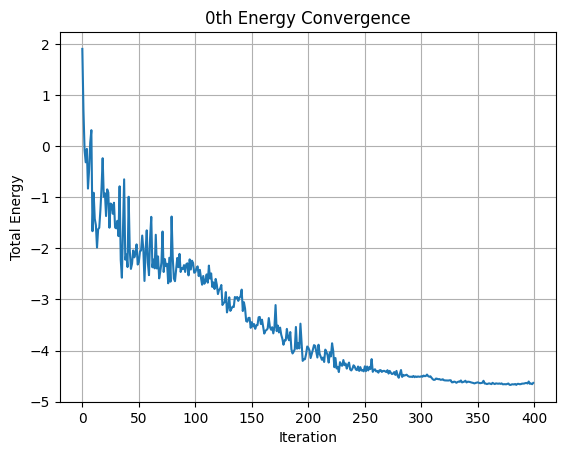

Converged Energy : -4.634916784945692


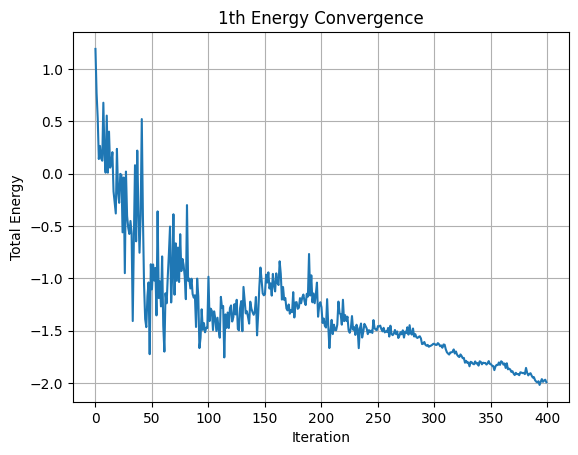

Converged Energy : -1.994185527451569


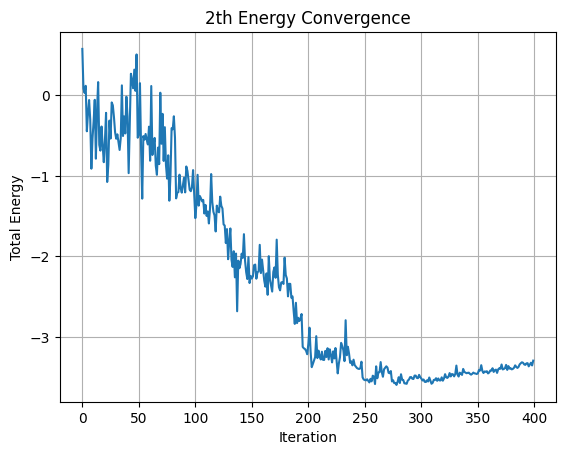

Converged Energy : -3.2915296349899577


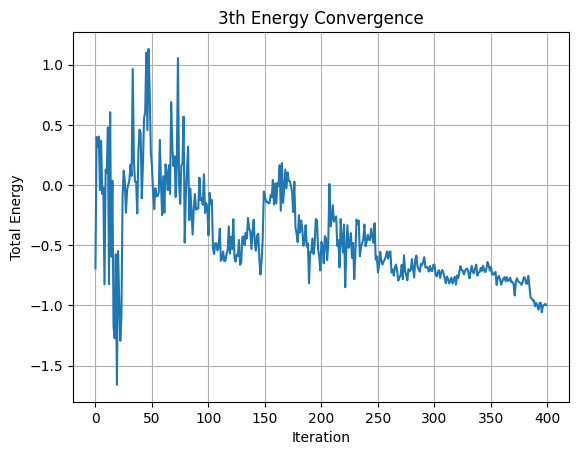

Converged Energy : -0.9968426314543016


In [18]:
for i in range(num_qubits):

    plt.plot(cost_history_dict["eigenstates_energies"][i])
    plt.xlabel("Iteration")
    plt.ylabel("Total Energy")
    plt.title(f"{i}th Energy Convergence")
    plt.grid()
    plt.show()

    iters = cost_history_dict["iters"] - 1
    converged_energy = cost_history_dict["eigenstates_energies"][i][iters]
    print(f"Converged Energy : {converged_energy}")